In [3]:
# import necessary libraries
import numpy as np
import torchaudio
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


In [4]:
# load wav files from folder Audio_Files
# there are two types of files: Major and Minor
Major_waveforms = []
Minor_waveforms = []
for filename in os.listdir('Audio_Files/Major'):
    if filename.endswith(".wav"):
        wav_path = os.path.join('Audio_Files/Major', filename)
        waveform, sample_rate = torchaudio.load(wav_path, normalize=True)
        Major_waveforms.append((waveform[0].numpy(), sample_rate))

for filename in os.listdir('Audio_Files/Minor'):
    if filename.endswith(".wav"):
        wav_path = os.path.join('Audio_Files/Minor', filename)
        waveform, sample_rate = torchaudio.load(wav_path, normalize=True)
        Minor_waveforms.append((waveform[0].numpy(), sample_rate))

In [8]:
def non_ml_classifier(waveform, sample_rate, detect_peaks=500, plot=False, real_label=None):
    # 0: Minor
    # 1: Major
    n = len(waveform)
    yf = np.fft.fft(waveform)
    xf = np.fft.fftfreq(n, 1 / sample_rate)
    freqs = xf[:n // 2]
    mag = 2.0 / n * np.abs(yf[:n // 2])
    idx = np.argsort(mag)
    if freqs[idx[-1]] > 0:
        root_freq = freqs[idx[-1]]
        root_mag = mag[idx[-1]]
        peak_idx = idx[-detect_peaks:-1]
    else:
        root_freq = freqs[idx[-2]]
        root_mag = mag[idx[-2]]
        peak_idx = idx[-detect_peaks:-2]
    # detect major third or minor third
    major_third = root_freq * 2 ** (1/3)
    minor_third = root_freq * 2 ** (1/4)

    major_third_dist = np.min(np.abs(freqs[peak_idx] - major_third))
    minor_third_dist = np.min(np.abs(freqs[peak_idx] - minor_third))



    if plot:
        # plt.plot(freqs, mag)
        # print(root_freq, major_third, minor_third)
        # print(freqs[peak_idx])
        # print(major_third_dist, minor_third_dist) 
        plt.plot([root_freq, root_freq], [0, root_mag], 'b-*')
        plt.plot(freqs[peak_idx], mag[peak_idx], 'r*')
        plt.plot([major_third, major_third], [0, 0.1], 'g-')
        plt.plot([minor_third, minor_third], [0, 0.1], 'y-')

        # plot root harmonics
        for i in range(1, 4):
            plt.plot([root_freq * i, root_freq * i], [0, 0.1], 'b--')
        
        # plot major third harmonics
        for i in range(1, 4):
            plt.plot([major_third * i, major_third * i], [0, 0.1], 'g--')

        # plot minor third harmonics
        for i in range(1, 4):
            plt.plot([minor_third * i, minor_third * i], [0, 0.1], 'y--')

        plt.legend(['Root', 'Peaks', 'Major Third', 'Minor Third', 'Root Harmonics', 'Major Third Harmonics', 'Minor Third Harmonics'])
        plt.title(f'Real: {real_label}; Predicted: {"Major" if major_third_dist < minor_third_dist else "Minor"}')
        plt.show()

    if major_third_dist < minor_third_dist:
        return 1
    else:
        return 0


In [20]:

def non_ml_classifier_scipy(waveform, sample_rate, detect_peaks=50, plot=False, real_label=None):
    # 0: Minor
    # 1: Major
    n = len(waveform)
    yf = np.fft.fft(waveform)
    xf = np.fft.fftfreq(n, 1 / sample_rate)
    freqs = xf[:n // 2]
    mag = 2.0 / n * np.abs(yf[:n // 2])
    idx = np.argsort(mag)

    # find peaks
    peaks, _ = find_peaks(mag, height=0.01)
    peak_freqs = freqs[peaks]
    peak_mags = mag[peaks]

    peak_idx = np.argsort(peak_mags)[-detect_peaks:]

    possible_roots_idx = peak_idx

    min_perfect_fifth_dist = np.inf
    root = None

    for i in possible_roots_idx:
        root_freq = peak_freqs[i]
        if root_freq < 0:
            continue

        # detect perfect fifth
        perfect_fifth = root_freq * 2 ** (7/12)
        perfect_fifth_dist = np.min(np.abs(peak_freqs - perfect_fifth))
        if perfect_fifth_dist < min_perfect_fifth_dist:
            min_perfect_fifth_dist = perfect_fifth_dist
            root = root_freq
    
    # detect major third or minor third
    major_third = root * 2 ** (1/3)
    minor_third = root * 2 ** (1/4)

    major_third_dist = np.min(np.abs(peak_freqs - major_third))
    minor_third_dist = np.min(np.abs(peak_freqs - minor_third))

    if plot:
        # plt.plot(freqs, mag)
        # print(root_freq, major_third, minor_third)
        # print(freqs[peak_idx])
        # print(major_third_dist, minor_third_dist) 
        plt.plot([root, root], [0, peak_mags[i]], 'b-*')
        plt.plot(peak_freqs[peak_idx], peak_mags[peak_idx], 'r*')
        plt.plot([major_third, major_third], [0, 0.1], 'g-')
        plt.plot([minor_third, minor_third], [0, 0.1], 'y-')

        # plot root harmonics
        for i in range(1, 4):
            plt.plot([root * i, root * i], [0, 0.1], 'b--')
        
        # plot major third harmonics
        for i in range(1, 4):
            plt.plot([major_third * i, major_third * i], [0, 0.1], 'g--')

        # plot minor third harmonics
        for i in range(1, 4):
            plt.plot([minor_third * i, minor_third * i], [0, 0.1], 'y--')

        plt.legend(['Root', 'Peaks', 'Major Third', 'Minor Third', 'Root Harmonics', 'Major Third Harmonics', 'Minor Third Harmonics'])
        plt.title(f'Real: {real_label}; Predicted: {"Major" if major_third_dist < minor_third_dist else "Minor"}')
        plt.show()
    
    if major_third_dist < minor_third_dist:
        return 1
    else:
        return 0



In [6]:
# test the classifier
# print(non_ml_classifier(Major_waveforms[1][0], Major_waveforms[1][1]))
# test the classifier and calculate the accuracy
Major_correct = 0
Minor_correct = 0
for waveform, sample_rate in Major_waveforms:
    if non_ml_classifier(waveform, sample_rate, plot=False) == 1:
        Major_correct += 1
for waveform, sample_rate in Minor_waveforms:
    if non_ml_classifier(waveform, sample_rate, plot=False) == 0:
        Minor_correct += 1
print("Major Accuracy:", Major_correct / len(Major_waveforms))
print("Minor Accuracy:", Minor_correct / len(Minor_waveforms))
print("Overall Accuracy:", (Major_correct + Minor_correct) / (len(Major_waveforms) + len(Minor_waveforms)))





Major Accuracy: 0.549800796812749
Minor Accuracy: 0.5602240896358543
Overall Accuracy: 0.5541327124563445


In [21]:
# test the classifier
# print(non_ml_classifier(Major_waveforms[1][0], Major_waveforms[1][1]))
# test the classifier and calculate the accuracy
Major_correct = 0
Minor_correct = 0
for waveform, sample_rate in Major_waveforms:
    if non_ml_classifier_scipy(waveform, sample_rate, plot=False) == 1:
        Major_correct += 1
for waveform, sample_rate in Minor_waveforms:
    if non_ml_classifier_scipy(waveform, sample_rate, plot=False) == 0:
        Minor_correct += 1
print("Major Accuracy:", Major_correct / len(Major_waveforms))
print("Minor Accuracy:", Minor_correct / len(Minor_waveforms))
print("Overall Accuracy:", (Major_correct + Minor_correct) / (len(Major_waveforms) + len(Minor_waveforms)))





Major Accuracy: 0.6414342629482072
Minor Accuracy: 0.7535014005602241
Overall Accuracy: 0.6880093131548312


Major examples:


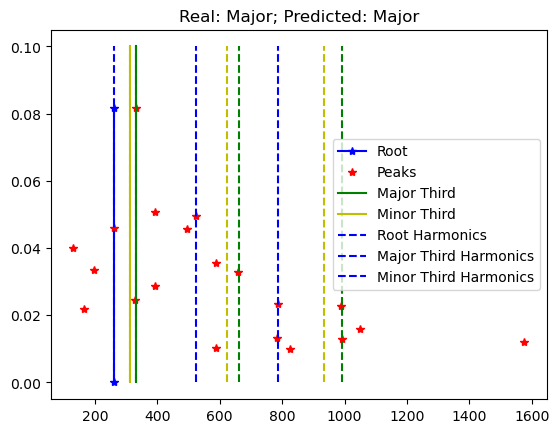

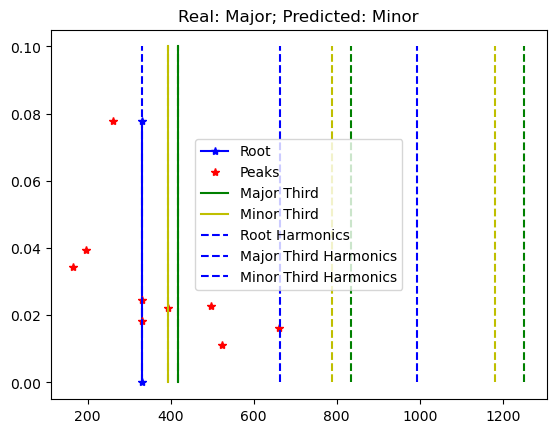

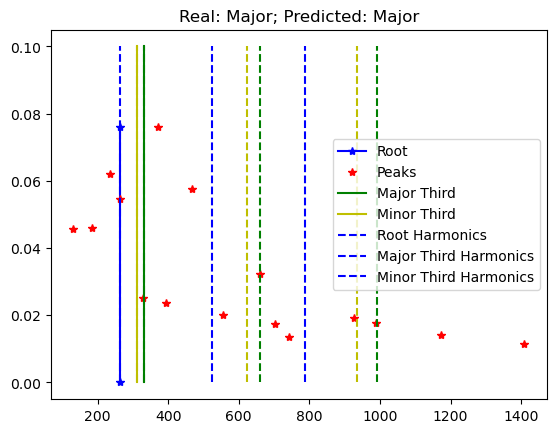

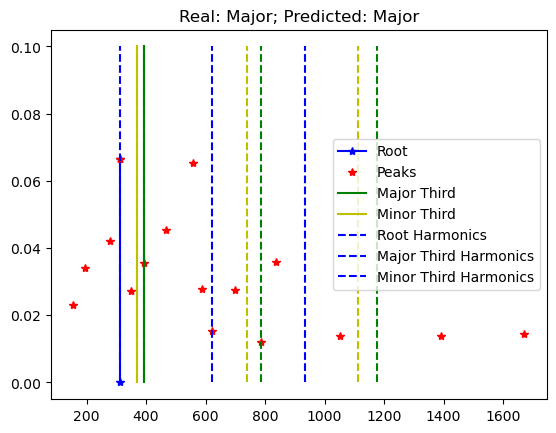

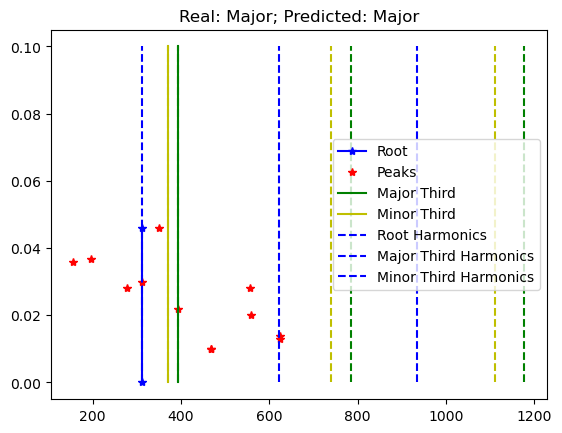

Minor examples:


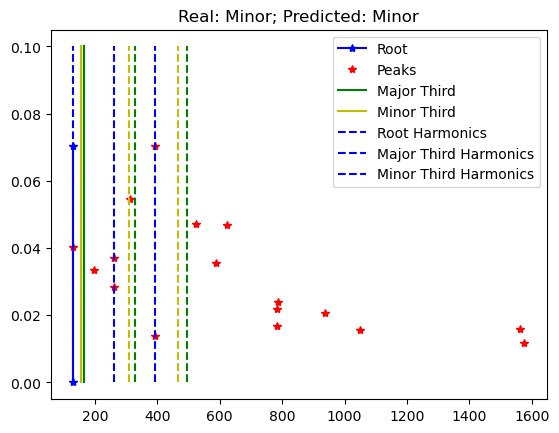

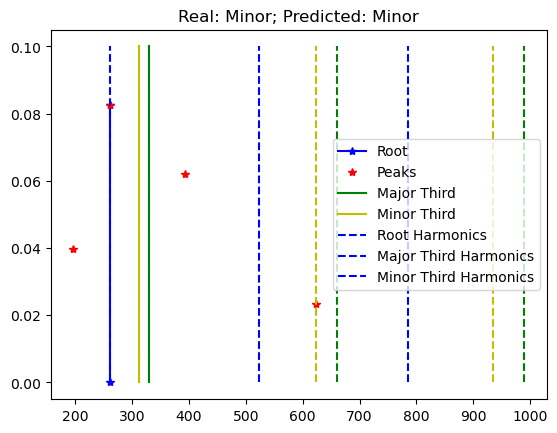

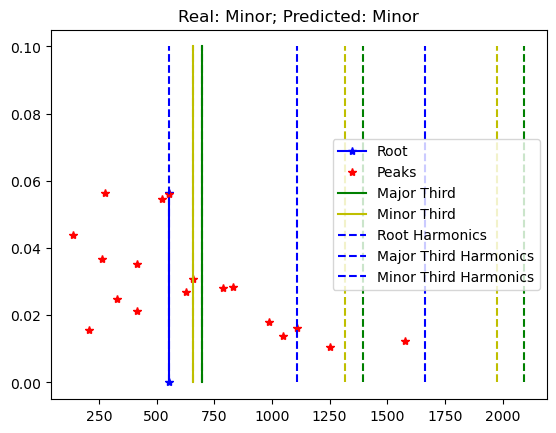

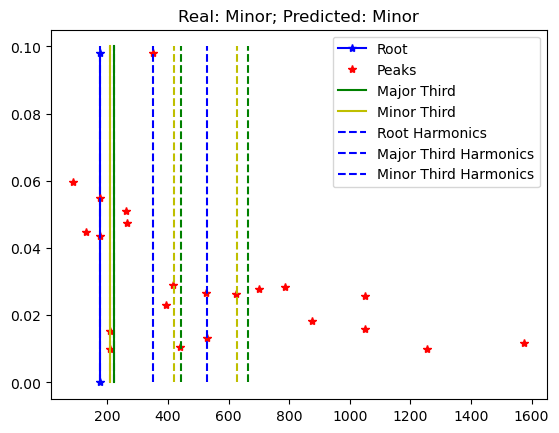

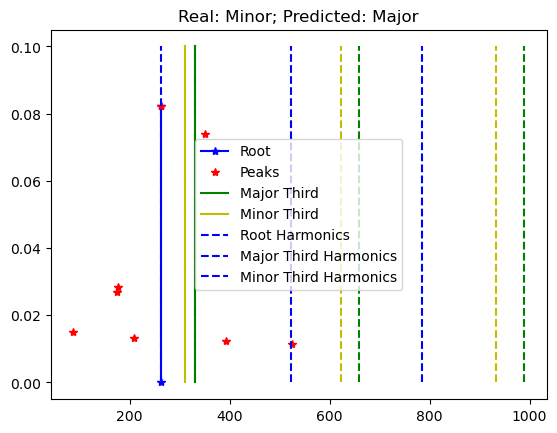

In [22]:
print('Major examples:')
for waveform, sample_rate in Major_waveforms[:5]:
    non_ml_classifier_scipy(waveform, sample_rate, plot=True, real_label='Major')

print('Minor examples:')
for waveform, sample_rate in Minor_waveforms[:5]:
    non_ml_classifier_scipy(waveform, sample_rate, plot=True, real_label='Minor')

Analysis: The major reason for the algorithm fail may be that the root note is not correctly identified.

Improvement: 
- May take harmonics into consideration.
- Use scipy.signal.find_peaks; Take perfect fifth into consideration to determine root note more accurately.
